In [33]:
import pandas as pd
import numpy as np
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

In [34]:
df = pd.read_table('nyt_data_counts_0518_concat.tsv', header=None, names=['id', 'author_gender', 'year', 'month',
                                                             'sections', 'tags', 'dist_m', 'dist_f',
                                                             'ment_m', 'ment_f', 'quotes_m', 'quotes_f', 
                                                             'quoted_words_m', 'quoted_words_f'])
df = df[df['year'] >= 1988]

In [35]:
sect_counts = defaultdict(int)
section_lists = [a for a in df['sections']]
for i, section_list in enumerate(section_lists):
    try:
        sections = section_list.split('; ')
    except:
        assert type(section_list) is float, section_list
    for section in sections:
        sect_counts[section] += 1

In [36]:
print sorted([(k, v) for (k, v) in sect_counts.iteritems()], key=lambda x: sect_counts[x[0]], reverse=True)

[('New York and Region', 51217), ('Front Page', 43234), ('Business', 42783), ('U.S.', 19370), ('Sports', 16347), ('World', 15950), ('Arts', 13089), ('Washington', 10675), ('Health', 9711), ('Technology', 9148), ('Education', 5930), ('Style', 5241), ('Movies', 4347), ('Home and Garden', 4003), ('Real Estate', 3475), ('Science', 3453), ('Books', 3363), ('Theater', 2767), ('Week in Review', 1934), ('Automobiles', 1334), ('Dining and Wine', 1211), ('Travel', 1013), ('Job Market', 631), ('Corrections', 463), ("Editors' Notes", 433), ('Obituaries', 281), ('Magazine', 56), ('Opinion', 41), ('Paid Death Notices', 26)]


In [5]:
for key in sect_counts:
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    print key, len(sect_df)

Arts 12991
Editors' Notes 428
Job Market 625
Travel 983
Style 5209
Sports 16238
Week in Review 1929
Health 9643
Front Page 42969
Business 42487
Automobiles 1327
Home and Garden 3985
Obituaries 278
World 15839
Theater 2744
Paid Death Notices 26
Science 3427
U.S. 19250
Movies 4300
Magazine 55
New York and Region 50835
Corrections 456
Opinion 41
Dining and Wine 1207
Washington 10609
Books 3345
Real Estate 3449
Education 5876
Technology 9095


In [11]:
df.describe()

,year,month,dist_m,dist_f,ment_m,ment_f,quotes_m,quotes_f,quoted_words_m,quoted_words_f
count,177767.000000,177767.000000,177522.000000,177522.000000,177522.000000,177522.000000,177522.000000,177522.000000,177522.000000,177522.000000
mean,1997.320779,6.546643,4.819803,1.322321,13.640135,3.388481,4.819803,1.322321,20.120103,5.820541
std,5.238194,3.466471,4.138504,2.161403,15.265148,7.349132,4.138504,2.161403,61.348035,32.658334
min,1988.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,3.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,1998.000000,7.000000,4.000000,1.000000,9.000000,1.000000,4.000000,1.000000,0.000000,0.000000
75%,2002.000000,10.000000,7.000000,2.000000,19.000000,3.000000,7.000000,2.000000,0.000000,0.000000
max,2005.000000,12.000000,93.000000,55.000000,255.000000,193.000000,93.000000,55.000000,1120.000000,1355.000000


In [6]:
def display_table(groupedby):
    """
    Take a grouped by object and display summaries of counts, sums and
    ratios across it.
    """
    agg_dict = OrderedDict([('month', {'count': 'count'})] + [
        (col, {'sum': np.sum}) for col in ['dist_m', 'dist_f', 'ment_m', 'ment_f', 'quotes_m', 'quotes_f',
                                           'quoted_words_m', 'quoted_words_f']])
    agg_table = groupedby.aggregate(agg_dict)
    for counts in ['dist', 'ment', 'quotes', 'quoted_words']:
        sum_ = agg_table[counts + '_m'] + agg_table[counts + '_f']
        for gend in ['f']:
            agg_table['{}_{}_ratio'.format(counts, gend)] = agg_table[counts + '_' + gend]/sum_
    return agg_table

In [7]:
def plot_ratio_over_time(df, criterion, gender, desc='', only_women=False, start_year=None, end_year=None):
    """
    Criterion is something like 'ment', 'dist' or 'quotes'
    gender is 'm' or 'f'.
    This is a plot of how the ratio of that gender's counts
    in criterion have changed over time.
    """
    gender = gender.lower()[0]
    gender_to_string = {
        'm': 'males',
        'f': 'females'
    }
    criterion_to_string = {
        'ment': 'Total mentions',
        'dist': 'Mentions in articles',
        'quotes': 'People Quoted',
        'quoted_words': 'Quoted words'
    }
    if start_year:
        df = df[df['year'] >= start_year]
    if end_year:
        df = df[df['year'] <= end_year]
    gb_y = df.groupby(['year'])
    gb_gend = df.groupby(['author_gender'])
    plot_col = '{}_{}_ratio'.format(criterion, gender)
    agg_table_y = display_table(gb_y)
    ri = agg_table_y.reset_index()
    
    fig, ax = plt.subplots()
    # Be sure to only pick integer tick locations.
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # plt.gca().xaxis.set_ticklabels([str(a) for a in list(ri['year'])])
    plt.plot(ri['year'], ri[plot_col], label=desc if only_women else 'Total')
    # print ri['year'], '\n'.join([str(a) for a in ri[plot_col]])

    plt.xlabel('Year')
    if criterion == 'quoted_words':
        plt.ylabel('Fraction of words spoken by women')
    else:
        plt.ylabel('Fraction of {} among {}{}'.format(gender_to_string[gender], criterion_to_string[criterion],
                  ' in {}'.format(desc) if desc and not only_women else ''))
    if not only_women:
        for key, grp in df.groupby(['author_gender']):
            if key not in ['MALE', 'FEMALE']:
                continue
            table = display_table(grp.groupby(['year']))
            ri = table.reset_index()
            # print key.title()
            # print ri['year'], '\n'.join([str(a) for a in ri[plot_col]])
            plt.plot(ri['year'], ri[plot_col], label = '{} authors'.format(key.title()))
    plt.legend(loc='upper left')

In [8]:
def plot_fraction_women_authors_over_time(df, desc=''):
    gb_year_gend = df.groupby(['year', 'author_gender']).aggregate({'dist_f': {'count': 'count'}}).reset_index()
    ratios = {}
    for year in range(1989, 2006):
        gb_year = gb_year_gend[gb_year_gend['year'] == year]
        counts = {}
        for gend in ['FEMALE', 'MALE']:
            counts[gend] = gb_year[gb_year['author_gender'] == gend].iloc[0][2]
        ratios[year] = float(counts['FEMALE'])/(counts['FEMALE'] + counts['MALE'])
    plt.plot(sorted(ratios), [ratios[year] for year in sorted(ratios)], label=desc)
    plt.title('Fraction of articles written by women over time')
    plt.gcf().set_size_inches(10, 6)
    plt.legend(loc='upper left')
    # plt.savefig('Authors_over_time{}.png'.format('_{}'.format(desc) if desc else ''), dpi=100)

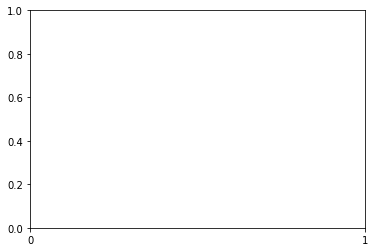

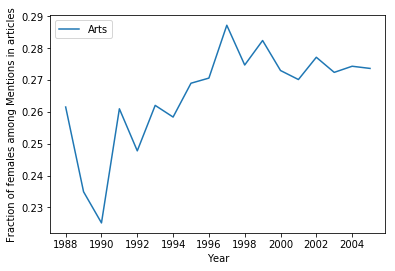

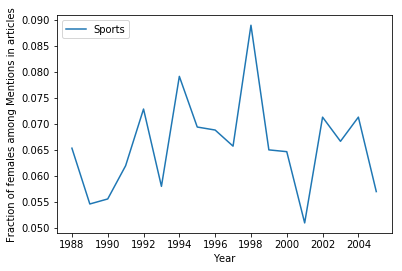

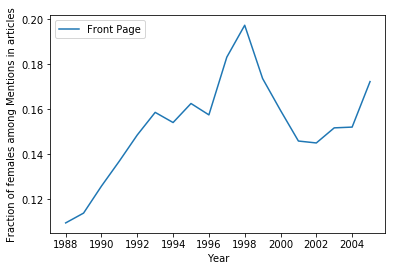

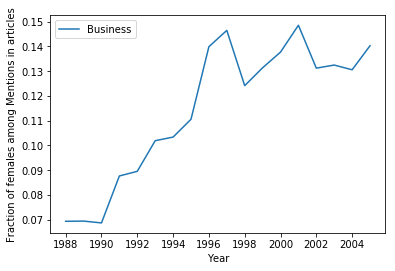

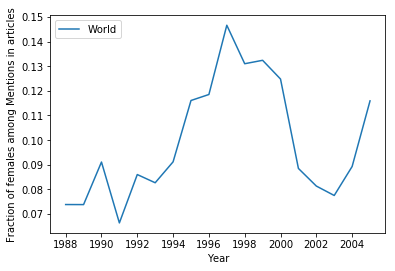

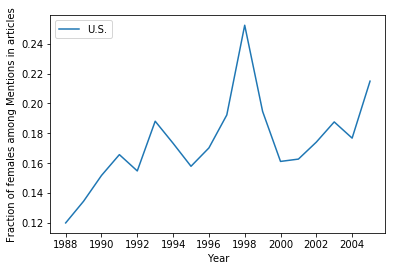

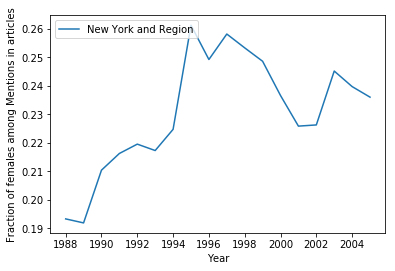

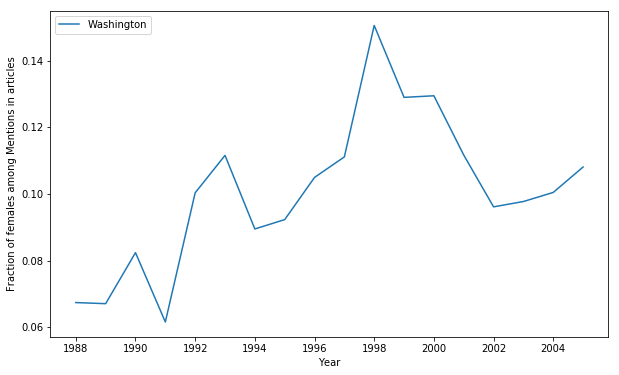

In [17]:
fig, ax = plt.subplots()
# Be sure to only pick integer tick locations.
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for key in sect_counts:
    

    if sect_counts[key] < 10000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    plot_ratio_over_time(sect_df, 'dist', 'f', key, True)

plt.gcf().set_size_inches(10, 6)
plt.savefig('Distinct_mentions_over_time_for_women.png', dpi=100)


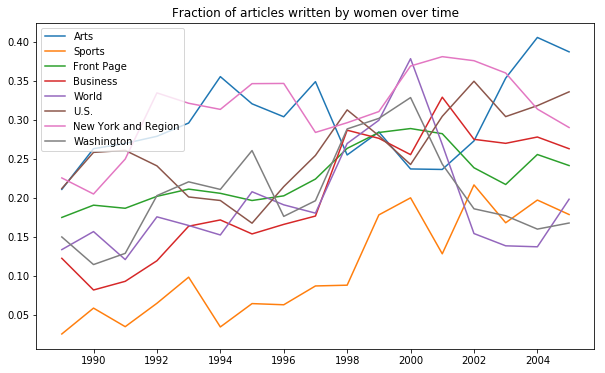

In [18]:
fig, ax = plt.subplots()
# Be sure to only pick integer tick locations.
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for key in sect_counts:
    if sect_counts[key] < 10000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    plot_fraction_women_authors_over_time(sect_df, key)

plt.gcf().set_size_inches(10, 6)
plt.savefig('Fraction_women_writers_over_time.png', dpi=100)

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


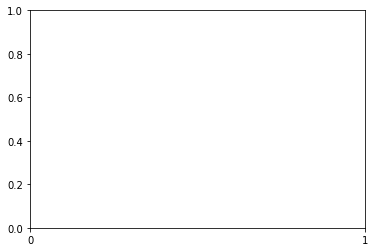

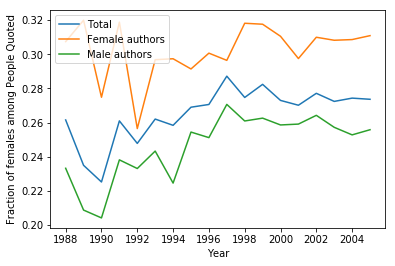

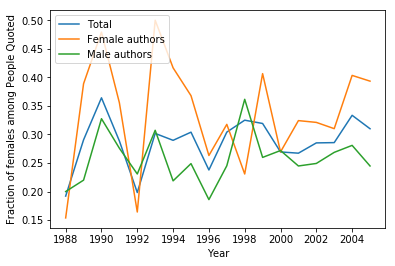

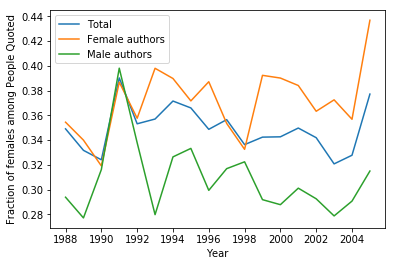

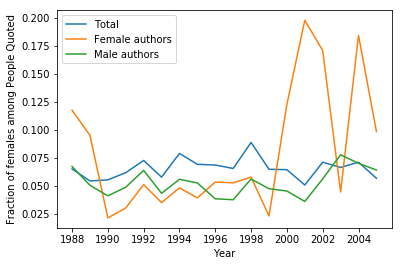

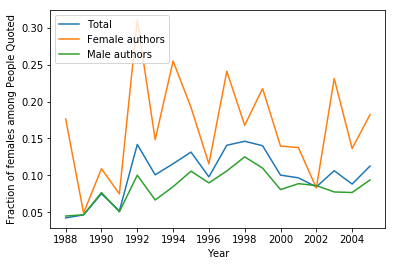

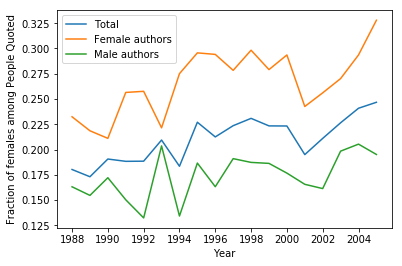

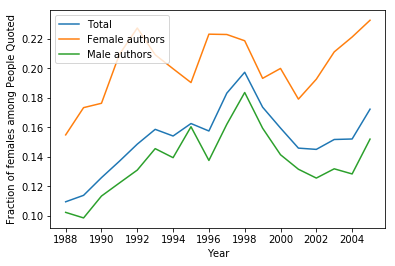

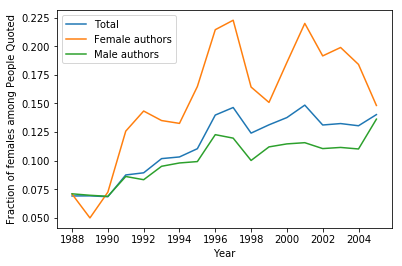

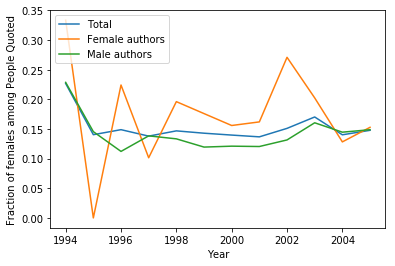

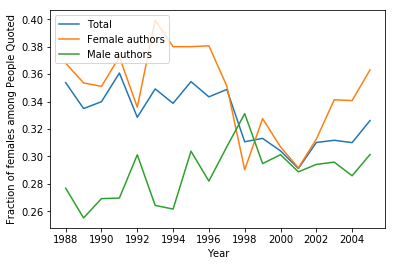

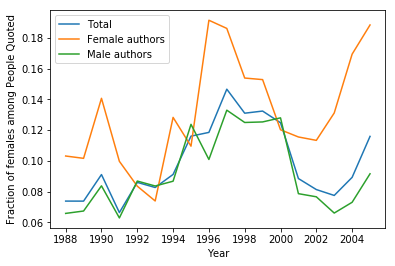

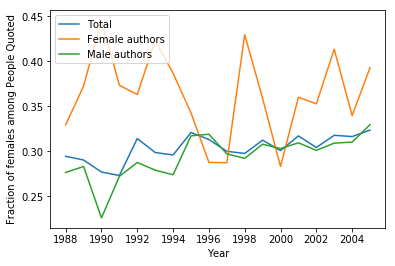

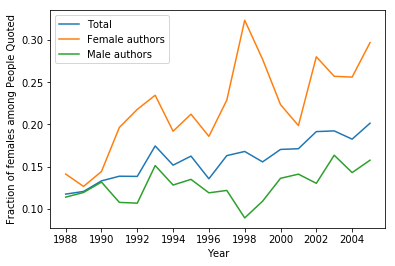

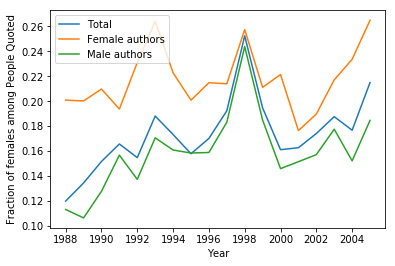

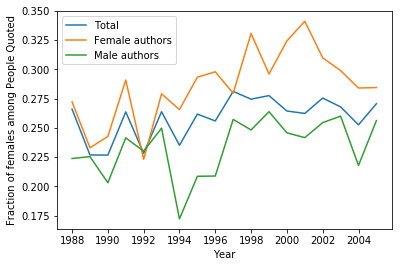

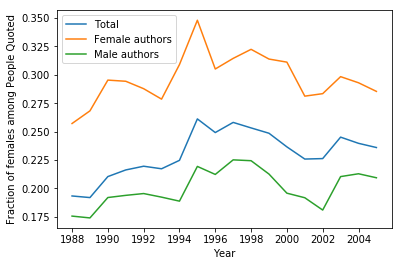

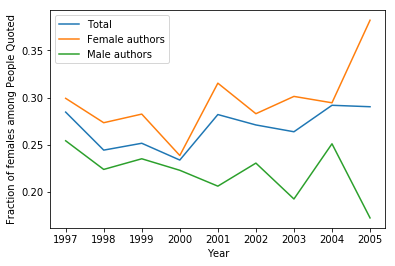

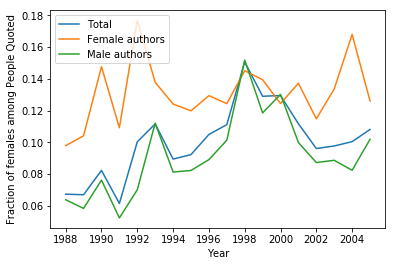

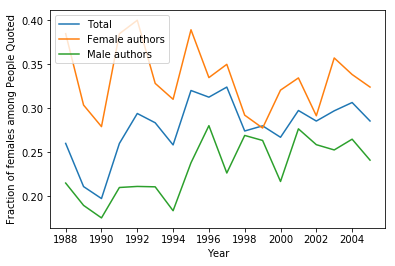

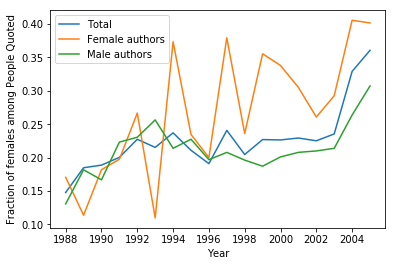

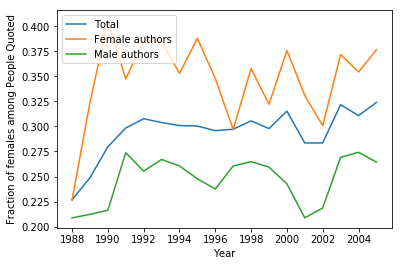

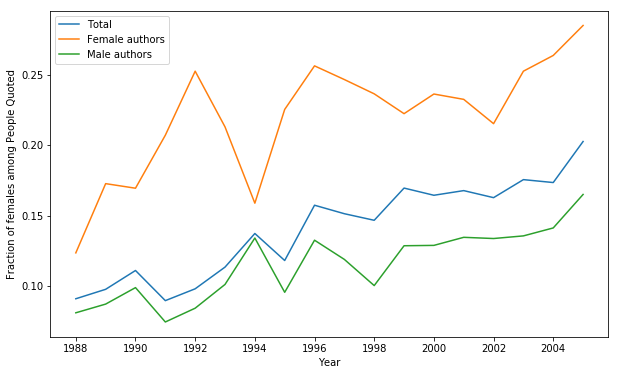

In [19]:
fig, ax = plt.subplots()
# Be sure to only pick integer tick locations.
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for key in sect_counts:
    

    if sect_counts[key] < 1000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    plot_ratio_over_time(sect_df, 'quotes', 'f')

plt.gcf().set_size_inches(10, 6)
plt.savefig('Quotes_over_time_for_women.png'.format(key), dpi=100)

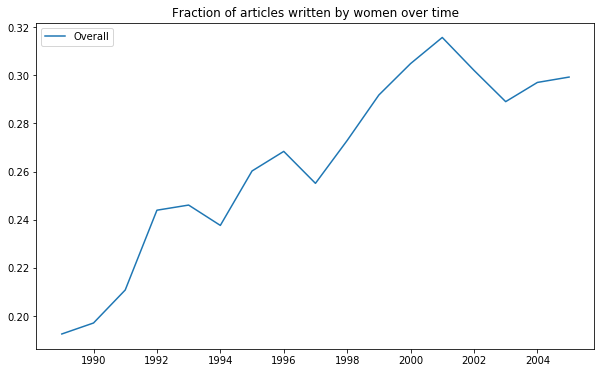

In [9]:
plot_fraction_women_authors_over_time(df, 'Overall')

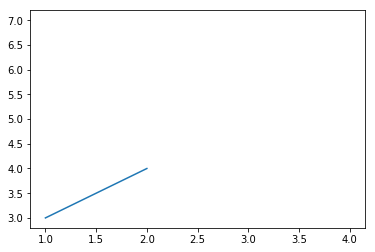

In [52]:
plt.plot([1, 2], [3, 4])
plt.plot([4], [7])

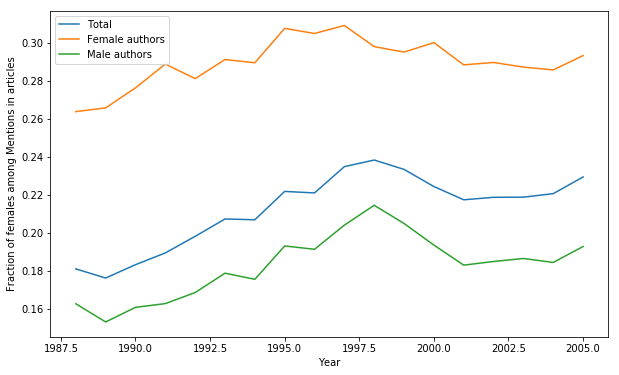

In [23]:
plot_ratio_over_time(df, 'dist', 'f')
plt.gcf().set_size_inches(10, 6)
plt.savefig('Distinct_mentions_over_time_NYT.png', dpi=100)

In [88]:
for key in sect_counts:
    if sect_counts[key] < 5000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    male_quotes = sect_df['quotes_m'].sum()
    female_quotes = sect_df['quotes_f'].sum()
    print key
    # print female_quotes/(male_quotes + female_quotes)

Arts
Style
Sports
Health
Front Page
Business
World
U.S.
New York and Region
Washington
Education
Technology


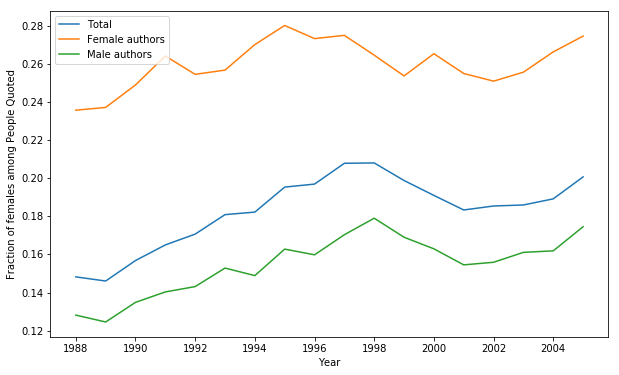

In [10]:
plot_ratio_over_time(df, 'quotes', 'f')
plt.gcf().set_size_inches(10, 6)
plt.savefig('Quotes_over_time_NYT.png', dpi=100)

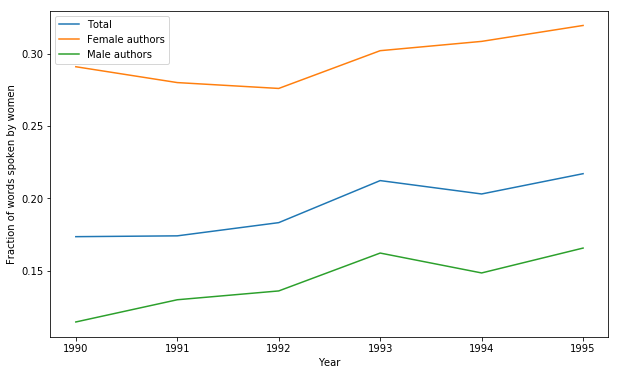

In [11]:
plot_ratio_over_time(df, 'quoted_words', 'f', start_year=1990, end_year=1995)
plt.gcf().set_size_inches(10, 6)
plt.savefig('Quoted_words_over_time_NYT.png', dpi=100)

In [20]:
print 'Section, fraction of male authors, perc_f overall, perc_f male authors, perc_f female authors'
for key in sect_counts:
    if sect_counts[key] < 5000:
        continue
    
    pers = {}
    
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    male_quotes = sect_df['quoted_words_m'].sum()
    female_quotes = sect_df['quoted_words_f'].sum()
    percentage_overall = (female_quotes)/(male_quotes + female_quotes)
    
    authors = {}
    for gend in ['MALE', 'FEMALE']:
        gend_df = sect_df[df['author_gender'] == gend]
        authors[gend] = len(gend_df)
        male_quotes = gend_df['quoted_words_m'].sum()
        female_quotes = gend_df['quoted_words_f'].sum()
        pers[gend] = (female_quotes)/(male_quotes + female_quotes)
    
    
    print [str(a) for a in [key, float(authors['MALE'])/sum(authors.values()), percentage_overall,
                    pers['MALE'], pers['FEMALE']]]

Section, fraction of male authors, perc_f overall, perc_f male authors, perc_f female authors
['Arts', '0.696109839817', '0.261734719007', '0.194906830053', '0.352019963']


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


['Style', '0.422222222222', '0.437208798758', '0.377871239081', '0.453378083489']
['Sports', '0.859622125331', '0.0721888253734', '0.0402069797628', '0.0456032980577']
['Health', '0.665500507843', '0.202508088558', '0.152953788304', '0.264518262553']
['Front Page', '0.774845796088', '0.166901059672', '0.142781220666', '0.22847971181']
['Business', '0.78295687885', '0.0985470218457', '0.0887946501808', '0.135372070506']
['World', '0.812230052285', '0.103647998857', '0.102050602497', '0.116957312744']
['U.S.', '0.747240172321', '0.184395796221', '0.160221339299', '0.247709473189']
['New York and Region', '0.689813037186', '0.257465743325', '0.20000427183', '0.338042090877']
['Washington', '0.796805310652', '0.0908961317979', '0.0732898525656', '0.141582989638']
['Education', '0.57345971564', '0.334480259614', '0.267206194612', '0.419231483775']
['Technology', '0.781131178707', '0.119262890649', '0.10050559744', '0.226605868358']


In [14]:
print 'Section, fraction of male authors, perc_f overall, perc_f male authors, perc_f female authors'
for key in sect_counts:
    if sect_counts[key] < 5000:
        continue
    
    pers = {}
    
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    male_quotes = sect_df['dist_m'].sum()
    female_quotes = sect_df['dist_f'].sum()
    percentage_overall = (female_quotes)/(male_quotes + female_quotes)
    
    authors = {}
    for gend in ['MALE', 'FEMALE']:
        gend_df = sect_df.loc[df['author_gender'] == gend]
        authors[gend] = len(gend_df)
        male_quotes = gend_df['dist_m'].sum()
        female_quotes = gend_df['dist_f'].sum()
        pers[gend] = (female_quotes)/(male_quotes + female_quotes)
    
    
    print [str(a) for a in [key, float(authors['MALE'])/sum(authors.values()), percentage_overall,
                    pers['MALE'], pers['FEMALE']]]

Section, fraction of male authors, perc_f overall, perc_f male authors, perc_f female authors
['Arts', '0.696109839817', '0.269899827898', '0.251832882125', '0.305608119732']
['Style', '0.422222222222', '0.346878250358', '0.299630673921', '0.376710981197']
['Sports', '0.859622125331', '0.0656275267272', '0.0541020620836', '0.106568814926']
['Health', '0.665500507843', '0.21174467245', '0.176003753876', '0.26808028741']
['Front Page', '0.774845796088', '0.152770542512', '0.136375074141', '0.203170468087']
['Business', '0.78295687885', '0.117605254227', '0.102642069157', '0.1700582256']
['World', '0.812230052285', '0.0967131439034', '0.0881749912043', '0.132898021894']
['U.S.', '0.747240172321', '0.17306384885', '0.158248486058', '0.218807228118']
['New York and Region', '0.689813037186', '0.232298857361', '0.199996324273', '0.29838022972']
['Washington', '0.796805310652', '0.101784611766', '0.0914576681249', '0.132845336482']
['Education', '0.57345971564', '0.297123088128', '0.247188002